# MODEL TRAINING

## 1. Importing data and required packages

#### 1.1 import modeules

In [1]:
# Basic import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

# Modelling
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

# Column Transformers
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# separate dataset into train & test
from sklearn.model_selection import train_test_split

#### 1.2 import cleaned data as pandas dataframe

In [2]:
car_data = pd.read_csv('data/cleaned_car_data.csv', index_col=0)

In [3]:
car_data

,name,company,year,Price,kms_driven,fuel_type
0,Hyundai Santro Xing,Hyundai,2007,80000,45000,Petrol
1,Mahindra Jeep CL550,Mahindra,2006,425000,40,Diesel
2,Hyundai Grand i10,Hyundai,2014,325000,28000,Petrol
3,Ford EcoSport Titanium,Ford,2014,575000,36000,Diesel
4,Ford Figo,Ford,2012,175000,41000,Diesel
...,...,...,...,...,...,...
810,Maruti Suzuki Ritz,Maruti,2011,270000,50000,Petrol
811,Tata Indica V2,Tata,2009,110000,30000,Diesel
812,Toyota Corolla Altis,Toyota,2009,300000,132000,Petrol
813,Tata Zest XM,Tata,2018,260000,27000,Diesel


In [4]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 815 entries, 0 to 814
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        815 non-null    object
 1   company     815 non-null    object
 2   year        815 non-null    int64 
 3   Price       815 non-null    int64 
 4   kms_driven  815 non-null    int64 
 5   fuel_type   815 non-null    object
dtypes: int64(3), object(3)
memory usage: 44.6+ KB


## 2. Preparation of Model Calculation

#### 2.1 Preparing x & y variables

In [5]:
x = car_data.drop(columns=['Price'], axis=1)
y = car_data['Price']

In [6]:
x.head()

,name,company,year,kms_driven,fuel_type
0,Hyundai Santro Xing,Hyundai,2007,45000,Petrol
1,Mahindra Jeep CL550,Mahindra,2006,40,Diesel
2,Hyundai Grand i10,Hyundai,2014,28000,Petrol
3,Ford EcoSport Titanium,Ford,2014,36000,Diesel
4,Ford Figo,Ford,2012,41000,Diesel


In [7]:
y.head()

0     80000
1    425000
2    325000
3    575000
4    175000
Name: Price, dtype: int64

In [8]:
numeric_features = [feature for feature in x.columns if x[feature].dtype != 'O']
categorical_features = [feature for feature in x.columns if x[feature].dtype == 'O']

print('We have {} numerical features in x: {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features in x : {}'.format(len(categorical_features), categorical_features))

We have 2 numerical features in x: ['year', 'kms_driven']

We have 3 categorical features in x : ['name', 'company', 'fuel_type']


#### 2.2 Creating an OneHotEncoder object to contain all the possible categories

In [9]:
ohe = OneHotEncoder()
ohe.fit(x[['name','company','fuel_type']])

OneHotEncoder()

#### 2.3 Creating a Column transformer to transform categorical columns

In [10]:
column_trans = make_column_transformer((OneHotEncoder(categories=ohe.categories_),['name','company','fuel_type']),
                                    remainder='passthrough')

#### 2.4 Model R2 calculator function

In [11]:
def model_R2_calc(x_data, y_data, column_trans, no_of_random_states):
    """
    This function calculates r2_score using different models.
    It takes input "x_data" as x data values, "y_data" as y data values,
    "column_trans" as column transformer to transform categorical value 
    and "no_of_random_states" as "random_state". It starts from 0 to (rand_state - 1).
    In the return, it gives - "random_state_data => list of random states", 
    "model_data => list of models that used to train at corresponding random state", 
    "r2_train_score_data => list of r2 score of train model w.r.t. that random state & model", 
    "r2_test_score_data => list of r2 score of test model w.r.t. that random state & model".
    """
    
    # Creating empty lists to store final outcome
    random_state_data = []
    model_data = []
    r2_train_score_data = []
    r2_test_score_data = []

    # creating model dictionary
    models = {
            "Linear Regression": LinearRegression(),
            # "Lasso": Lasso(max_iter=10000),
            "Ridge": Ridge(),
            "K-Neighbors Regressor": KNeighborsRegressor(),
            "Decision Tree": DecisionTreeRegressor(),
            "Random Forest Regressor": RandomForestRegressor(),
            "XGBRegressor": XGBRegressor(), 
            "CatBoosting Regressor": CatBoostRegressor(verbose=False),
            "AdaBoost Regressor": AdaBoostRegressor()
            }

    for i in range(no_of_random_states):
        # Training & Testing Dataset preparation
        x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=0.2, random_state=i)

        for j in range(len(models)):
            model = list(models.values())[j]

            # Making pipeline & fitting the model
            pipe = make_pipeline(column_trans, model)
            pipe.fit(x_train, y_train)

            # Evaluating prediction
            y_train_pred = pipe.predict(x_train)
            y_test_pred = pipe.predict(x_test)

            # calculating r2_score
            r2_train = r2_score(y_train, y_train_pred)
            r2_test =r2_score(y_test, y_test_pred)

            random_state_data.append(i)
            model_data.append(list(models.keys())[j])
            r2_train_score_data.append(round(r2_train, 4))
            r2_test_score_data.append(round(r2_test, 4))
    return random_state_data, model_data, r2_train_score_data, r2_test_score_data
            

In [12]:
rand_states, models, r2_score_train_data, r2_score_test_data = model_R2_calc(x, y, column_trans, 200)

#### 2.5 Best Model R2 selector function

In [16]:
def best_model_R2_selector(random_state_data, model_data, r2_train_score_data, r2_test_score_data):
    """
    This function selects best r2 score of model.
    It takes input "random_state_data" as list of random states, 
    "model_data" as list of models w.r.t. random states, 
    "r2_train_score_data" as list of r2 of train data w.r.t model & random state 
    & "r2_test_score_data"as list of r2 of train data w.r.t model & random state.
    In the return, it gives - "new_rand_state - best random state", 
    "new_model_list - list of best models to use at that random state", 
    "new_r2_train_list - best r2 score of train model w.r.t. that best random state & model", 
    "new_r2_test_list - bestr2 score of test model w.r.t. that best random state & model".
    """
     
    best_random_state_data = []
    best_model_data = []
    best_r2_train_score_data = []
    best_r2_test_score_data = []

    for k in range(len(random_state_data)):
        if (abs(r2_train_score_data[k] - r2_test_score_data[k]) < 0.1) and (r2_test_score_data[k] > 0.8):
            best_random_state_data.append(random_state_data[k])
            best_model_data.append(model_data[k])
            best_r2_train_score_data.append(r2_train_score_data[k])
            best_r2_test_score_data.append(r2_test_score_data[k])

    return best_random_state_data, best_model_data, best_r2_train_score_data, best_r2_test_score_data

In [17]:
best_rand_states, best_models, best_r2_score_train_data, best_r2_score_test_data  = best_model_R2_selector(
    rand_states, models, r2_score_train_data, r2_score_test_data
    )

In [20]:
dictionary = {
    "random state": best_rand_states, 
    "model name":best_models, 
    "r2 train data":best_r2_score_train_data, 
    "r2 test data":best_r2_score_test_data
    }
bestModelsDF = pd.DataFrame(dictionary)
bestModelsDF["difference"] = abs(bestModelsDF["r2 train data"] - bestModelsDF['r2 test data'])
bestModelsDF = bestModelsDF.sort_values(by=['r2 test data'], ascending=False).reset_index(drop=True)
bestModelsDF

,random state,model name,r2 train data,r2 test data,difference
0,124,XGBRegressor,0.9759,0.9086,0.0673
1,151,XGBRegressor,0.9762,0.8881,0.0881
2,4,XGBRegressor,0.9757,0.8877,0.0880
3,4,Random Forest Regressor,0.9526,0.8791,0.0735
4,172,CatBoosting Regressor,0.9409,0.8767,0.0642
5,124,CatBoosting Regressor,0.9442,0.8733,0.0709
6,151,CatBoosting Regressor,0.9405,0.8706,0.0699
7,151,Random Forest Regressor,0.9491,0.8646,0.0845
8,124,Random Forest Regressor,0.9462,0.8643,0.0819
9,27,Random Forest Regressor,0.9446,0.8568,0.0878


#### 2.4 Model Selection from best r2 selector function
- From the above r2 score table, selecting **XGBRegressor** as model at **random state = 124**.
- As difference between r2 score of train data & test data is less than **0.7**.

#### 2.5 Checking **XGBRegressor** for another **1000** iteration for best random state.

In [22]:
rand_state_ = []
r2_train_list_ =[]
r2_test_list_ =[]

for i in range(1000):
    # Training & Testing Dataset preparation
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2, random_state=i)

    # Making pipeline & fitting the model
    pipe = make_pipeline(column_trans, XGBRegressor())
    pipe.fit(x_train, y_train)

    # Evaluating prediction
    y_train_pred = pipe.predict(x_train)
    y_test_pred = pipe.predict(x_test)

    # calculating r2_score
    r2_train = r2_score(y_train, y_train_pred)
    r2_test =r2_score(y_test, y_test_pred)

    rand_state_.append(i)
    r2_train_list_.append(round(r2_train, 4))
    r2_test_list_.append(round(r2_test, 4))

In [30]:
new_rand_state_ = []
new_r2_train_list_ =[]
new_r2_test_list_ =[]
for k in range(len(rand_state_)):
    if (abs(r2_train_list_[k] - r2_test_list_[k]) < 0.1) and (r2_test_list_[k] > 0.8):
        new_rand_state_.append(rand_state_[k])
        new_r2_train_list_.append(r2_train_list_[k])
        new_r2_test_list_.append(r2_test_list_[k])

xgb_model_r2 = {
                'random state':new_rand_state_, 
                'r2 train data':new_r2_train_list_, 
                'r2 test data':new_r2_test_list_,
                }
xgb_model = pd.DataFrame(xgb_model_r2).sort_values(by=['r2 test data'], ascending=False).reset_index(drop=True)

In [32]:
xgb_model['difference'] = abs(xgb_model['r2 train data'] - xgb_model['r2 test data'])
xgb_model

,random state,r2 train data,r2 test data,difference
0,652,0.9754,0.9108,0.0646
1,124,0.9759,0.9086,0.0673
2,151,0.9762,0.8881,0.0881
3,4,0.9757,0.8877,0.0880
4,903,0.9786,0.8840,0.0946


## 3. Model - **XGBoost Regressor**

#### 3.1 Training XGBoost regressor Model

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=652)
xgb = XGBRegressor()
pipe = make_pipeline(column_trans, xgb)
pipe.fit(x_train, y_train)

# Make predictions
y_train_pred = pipe.predict(x_train)
y_test_pred = pipe.predict(x_test)

# Evaluate Train and Test dataset
print(round(r2_score(y_train, y_train_pred), 4))
print(np.round(r2_score(y_test, y_test_pred), 4))

0.9754
0.9108


#### 3.2 Plot y_predicted vs y_test

Text(0, 0.5, 'Predicted')

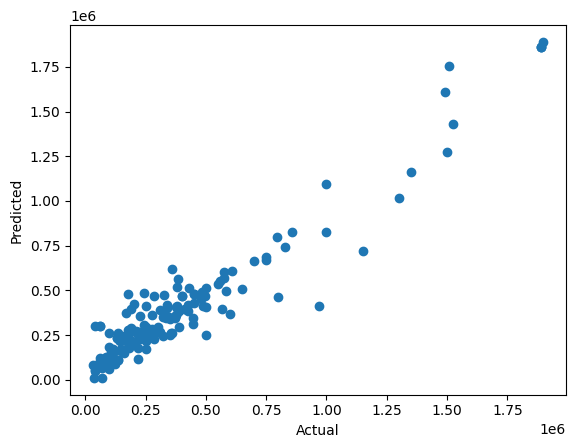

In [39]:
plt.scatter(y_test, y_test_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")

<Axes: xlabel='Price'>

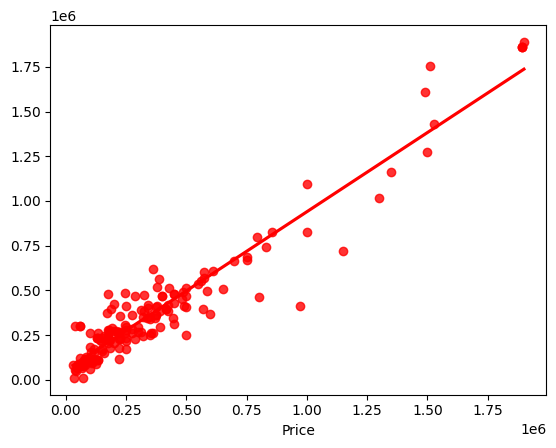

In [40]:
sns.regplot(x=y_test, y=y_test_pred, ci=None, color='red')

#### 3.3 Difference Between Actual & Predicted Values

In [41]:
pd.DataFrame({'Actual Value':y_test, 'Predicted Value':y_test_pred, 'Difference':(y_test-y_test_pred)})

,Actual Value,Predicted Value,Difference
653,135000,2.310972e+05,-96097.25000
475,149000,1.715378e+05,-22537.84375
645,1490000,1.611514e+06,-121514.25000
456,250000,2.929396e+05,-42939.62500
286,1891111,1.858916e+06,32195.37500
...,...,...,...
615,500000,2.477600e+05,252239.96875
93,210000,2.711654e+05,-61165.37500
535,199000,2.071421e+05,-8142.12500
382,450000,4.789633e+05,-28963.28125


## 4. Saving Trained and Testd Model - Linear Regressor

In [46]:
import pickle
path = "D:/All Files/Data Science/3. ML Projects/Car_Price_Predictor/model/"
pickle.dump(pipe, open((path + "car_price_pred_Model.pkl"), 'wb'))

In [42]:
print(round(r2_score(y_train, y_train_pred), 4))
print(np.round(r2_score(y_test, y_test_pred), 4))

0.9754
0.9108


In [45]:
pipe.predict(pd.DataFrame(columns=['name','company','year','kms_driven','fuel_type'],data=np.array(['Maruti Suzuki Swift','Maruti',2019,100,'Petrol']).reshape(1,5)))

array([584407.94], dtype=float32)